# Evaluating the Climate sensitivity of HR- and LR-CESM

In [1]:
import os
import sys
import numpy as np
import xesmf as xe
import xarray as xr
import cmocean
import cartopy
import scipy.stats as stats
import cartopy.crs as ccrs
import datetime
import matplotlib as mpl
import matplotlib.pyplot as plt

In [2]:
%matplotlib inline
mpl.rc_file('../rc_file')
%config InlineBackend.print_figure_kwargs={'bbox_inches':None}
%load_ext autoreload
%autoreload 2

In [3]:
sys.path.append("..")
from tqdm import notebook
from paths import path_results, path_prace, CESM_filename, file_ex_atm_lpd
from filters import lowpass
from constants import spy
from constants import R_earth
from xr_regression import xr_linear_trend, xr_lintrend, xr_2D_trends
from longrunmip_estimations import do_estimations
A_Earth = 4*np.pi*R_earth**2

In [4]:
# made in GMST.ipynb
gmst_ctrl = xr.open_dataarray(f'{path_results}/GMST/GMST_monthly_ctrl.nc', decode_times=False)
gmst_rcp  = xr.open_dataarray(f'{path_results}/GMST/GMST_monthly_rcp.nc' , decode_times=False)
gmst_hq   = xr.open_dataarray(f'{path_results}/GMST/GMST_monthly_hq.nc'  , decode_times=False)
gmst_lpd  = xr.open_dataarray(f'{path_results}/GMST/GMST_monthly_lpd.nc' , decode_times=False)
gmst_lr1  = xr.open_dataarray(f'{path_results}/GMST/GMST_monthly_lr1.nc' , decode_times=False)
gmst_lq   = xr.open_dataarray(f'{path_results}/GMST/GMST_monthly_lq.nc'  , decode_times=False)
gmst_ld   = xr.open_dataarray(f'{path_results}/GMST/GMST_monthly_ld.nc'  , decode_times=False)

In [5]:
GMST_h200  = xr.open_dataarray(f'{path_results}/GMST/GMST_monthly_ctrl.nc', decode_times=False).sel(time=slice(200*365,230*365)).mean()
GMST_l500  = xr.open_dataarray(f'{path_results}/GMST/GMST_monthly_lpd.nc' , decode_times=False).isel(time=slice(0,30*12)).mean()
GMST_l1200 = xr.open_dataarray(f'{path_results}/GMST/GMST_monthly_lpd.nc' , decode_times=False).isel(time=slice(690*12,720*12)).mean()

## SAT trend
originally in `GMST.ipynb`

In [6]:
%%time
kw = {'combine':'nested', 'concat_dim':'time', 'decode_times':False}
T_rcp = xr.open_mfdataset(f'{path_prace}/rcp/atm_yrly_T_T850_U_V_2*.nc', **kw)['T'][:100,-1,:,:]
T_lr1 = xr.open_mfdataset(f'{path_prace}/lr1/atm_yrly_T_T850_U_V_2*.nc', **kw)['T'][:100,-1,:,:]
T_hq  = xr.open_mfdataset(f'{path_prace}/hq/atm_yrly_T_T850_U_V_2*.nc' , **kw)['T'][:,-1,:,:]
T_lq  = xr.open_mfdataset(f'{path_prace}/lq/atm_yrly_T_T850_U_V_2*.nc' , **kw)['T'][:51,-1,:,:]

T_rcp_diff = T_rcp.isel(time=slice(-11,-1)).mean('time')-T_rcp.isel(time=slice(0,10)).mean('time')
T_lr1_diff = T_lr1.isel(time=slice(-11,-1)).mean('time')-T_lr1.isel(time=slice(0,10)).mean('time')
T_hq_diff  = T_hq .isel(time=slice(-11,-1)).mean('time')-T_hq .isel(time=slice(0,10)).mean('time')
T_lq_diff  = T_lq .isel(time=slice(-11,-1)).mean('time')-T_lq .isel(time=slice(0,10)).mean('time')

T_rcp_trend = (xr_2D_trends(T_rcp)*100*365)
T_lr1_trend = (xr_2D_trends(T_lr1)*100*365)
T_hq_trend  = (xr_2D_trends(T_hq )*100*365)
T_lq_trend  = (xr_2D_trends(T_lq )*100*365)

CPU times: user 6.81 s, sys: 5.76 s, total: 12.6 s
Wall time: 12.8 s


In [7]:
from xr_regression import xr_2D_trends


In [8]:
regridder = xe.Regridder(T_rcp, T_lr1, 'bilinear')

Overwrite existing file: bilinear_384x576_192x288.nc 
 You can set reuse_weights=True to save computing time.


#### maps of SAT trends / difference

/home/ajueling/.conda/envs/CESM/lib/python3.7/site-packages/xesmf/frontend.py:421: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  keep_attrs=keep_attrs


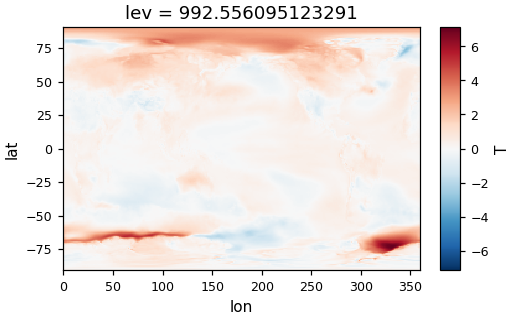

In [9]:
(regridder(T_rcp_diff) - T_lr1_diff).plot()

In [10]:
X1, Y1 = np.meshgrid(T_rcp.lon, T_rcp.lat)
X2, Y2 = np.meshgrid(T_lr1.lon, T_lr1.lat)

/home/ajueling/.conda/envs/CESM/lib/python3.7/site-packages/xesmf/frontend.py:421: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  keep_attrs=keep_attrs
/home/ajueling/.conda/envs/CESM/lib/python3.7/site-packages/xesmf/frontend.py:421: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  keep_attrs=keep_attrs
/home/ajueling/.conda/envs/CESM/lib/python3.7/site-packages/xesmf/frontend.py:421: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  keep_attrs=keep_attrs
/home/ajueling/.conda/envs/CESM/lib/python3.7/site-packages/xesmf/frontend.py:421: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.


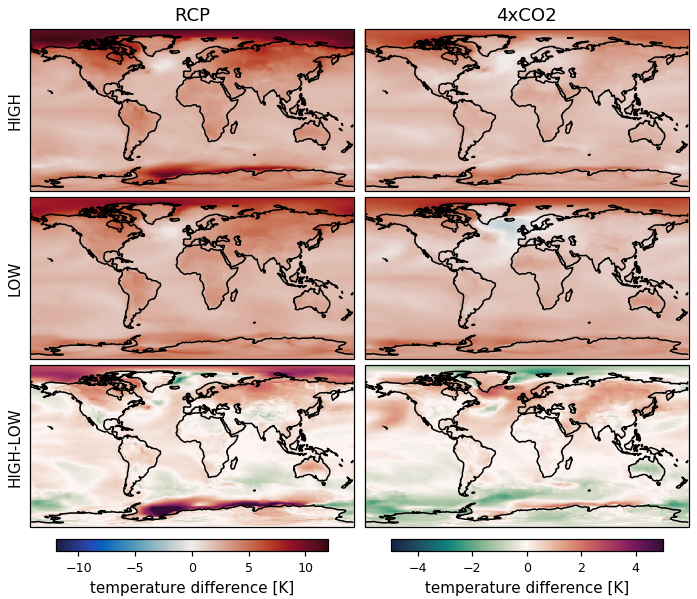

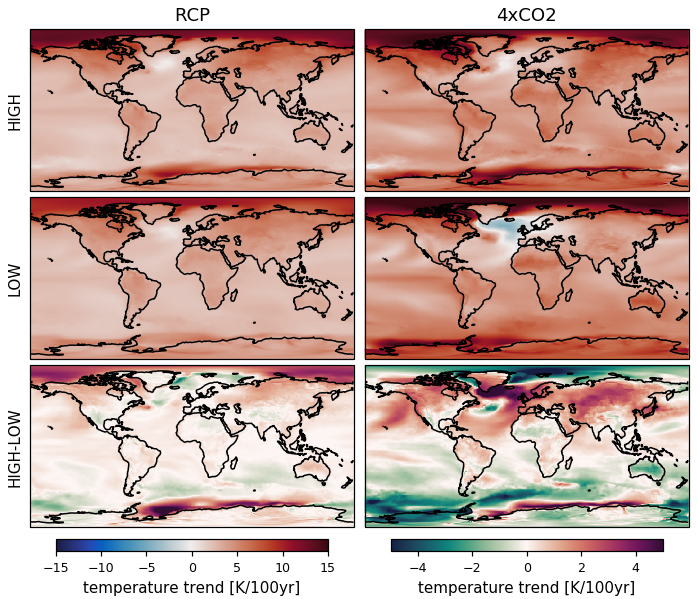

In [11]:
def comparison_maps(xa_list, kw1, kw2, label1=None, label2=None):
    """ makse 3x2 maps comparing HIGH/LOW RCP/4xCO2 runs"""
    f = plt.figure(figsize=(6.4,5.5))
    for i in range(3):
        for j in range(2):
            xa = xa_list[j][i]
            ax = f.add_axes([.04+.48*j, .68-i*.28, .47,.27], projection=ccrs.PlateCarree())
            if j==0:  ax.text(-.07,.5, ['HIGH','LOW','HIGH-LOW'][i], transform=ax.transAxes, rotation=90, va='center')
            if i==0:  ax.set_title(['RCP', '4xCO2'][j])

            if i<2:  kw = kw1
            else:    kw = kw2

            if i==0: X, Y = X1, Y1
            else:    X, Y = X2, Y2
            im = ax.pcolormesh(X, Y, xa, **kw)
            ax.coastlines()
            
            if j==0 and i>0:
                ax = f.add_axes([.08+.48*(i-1), .08, .39,.02])
                plt.colorbar(im, cax=ax, orientation='horizontal', label=[0,label1, label2][i])
    return

xa_list = [[T_rcp_diff, T_lr1_diff, regridder(T_rcp_diff) - T_lr1_diff],
           [T_hq_diff, T_lq_diff, regridder(T_hq_diff) - T_lq_diff]]
kw1 = {'vmin':-12, 'vmax':12, 'cmap':'cmo.balance'}
kw2 = {'vmin':-5, 'vmax':5, 'cmap':'cmo.curl'}
label = 'temperature difference [K]'
comparison_maps(xa_list, kw1, kw2, label, label)

xa_list = [[T_rcp_trend, T_lr1_trend, regridder(T_rcp_trend) - T_lr1_trend],
           [T_hq_trend, T_lq_trend, regridder(T_hq_trend) - T_lq_trend]]
kw1 = {'vmin':-15, 'vmax':15, 'cmap':'cmo.balance'}
kw2 = {'vmin':-5, 'vmax':5, 'cmap':'cmo.curl'}
label = 'temperature trend [K/100yr]'
comparison_maps(xa_list, kw1, kw2, label, label)

AMOC collapses in `lq`?

CPU times: user 1.26 s, sys: 560 ms, total: 1.82 s
Wall time: 1.77 s


Text(0.5, 1.0, 'SAT trend low res quadrupling')

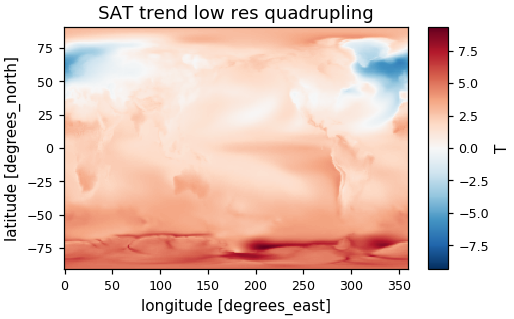

In [12]:
%%time
(xr_2D_trends(xr.open_mfdataset(f'{path_prace}/lq/atm_yrly_T_T850_U_V_2*.nc', **kw)['T'][:,-1,:,:])*100*365).plot(label='SAT trend [K/100yr]')
plt.title('SAT trend low res quadrupling')

### AMOC

Text(0.01, 0.01, '12 month running mean')

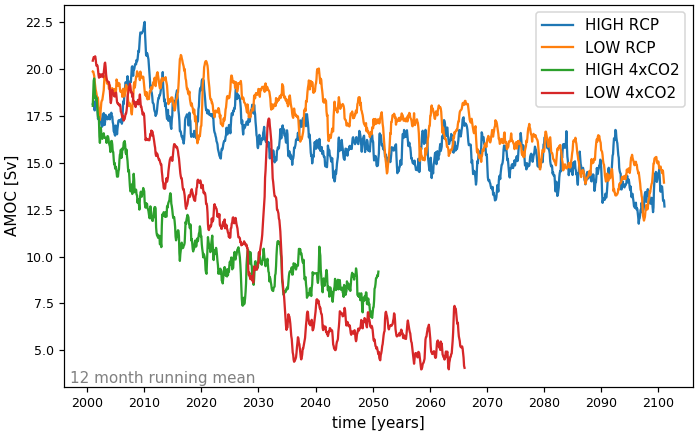

In [13]:
AMOC_rcp = xr.open_dataarray(f'{path_results}/MOC/AMOC_max_rcp.nc', decode_times=False)
AMOC_lr1 = xr.open_dataarray(f'{path_results}/MOC/AMOC_max_lr1.nc', decode_times=False)
AMOC_hq  = xr.open_dataarray(f'{path_results}/MOC/AMOC_max_hq.nc' , decode_times=False)
AMOC_lq  = xr.open_dataarray(f'{path_results}/MOC/AMOC_max_lq.nc' , decode_times=False)
plt.figure(figsize=(6.4,4))
plt.plot(AMOC_rcp.time/365, AMOC_rcp.rolling(time=12).mean(), label='HIGH RCP')
plt.plot(AMOC_lr1.time/365, AMOC_lr1.rolling(time=12).mean(), label='LOW RCP')
plt.plot(AMOC_hq .time/365, AMOC_hq .rolling(time=12).mean(), label='HIGH 4xCO2')
plt.plot(AMOC_lq .time/365, AMOC_lq .rolling(time=12).mean(), label='LOW 4xCO2')
plt.ylabel('AMOC [Sv]')
plt.xticks(np.arange(2000,2101,10))
plt.xlabel('time [years]')
plt.legend()
plt.text(.01,.01, '12 month running mean', c='grey', transform=plt.gca().transAxes)

#### meridional SAT trend

In [14]:
T_rcp_low = regridder(T_rcp).assign_coords({'time':T_lr1.time})
T_hq_low  = regridder(T_hq) .assign_coords({'time':T_lq .time})
T_rcp_zm = (T_rcp.mean('lon')-T_rcp.isel(time=slice(0,10)).mean(['lon','time'])).T
T_lr1_zm = (T_lr1.mean('lon')-T_lr1.isel(time=slice(0,10)).mean(['lon','time'])).T
T_hq_zm  = (T_hq .mean('lon')-T_hq .isel(time=slice(0,10)).mean(['lon','time'])).T
T_lq_zm  = (T_lq .mean('lon')-T_lq .isel(time=slice(0,10)).mean(['lon','time'])).T
T_rdiff_zm = ((T_rcp_low-T_lr1).mean('lon')-(T_rcp_low-T_lr1).isel(time=slice(0,10)).mean(['lon','time'])).T
T_qdiff_zm = ((T_hq_low -T_lq ).mean('lon')-(T_hq_low -T_lq ).isel(time=slice(0,10)).mean(['lon','time'])).T

/home/ajueling/.conda/envs/CESM/lib/python3.7/site-packages/xesmf/frontend.py:421: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  keep_attrs=keep_attrs
/home/ajueling/.conda/envs/CESM/lib/python3.7/site-packages/xesmf/frontend.py:421: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  keep_attrs=keep_attrs


CPU times: user 3.59 s, sys: 3.96 s, total: 7.55 s
Wall time: 7.06 s


(2000, 2050)

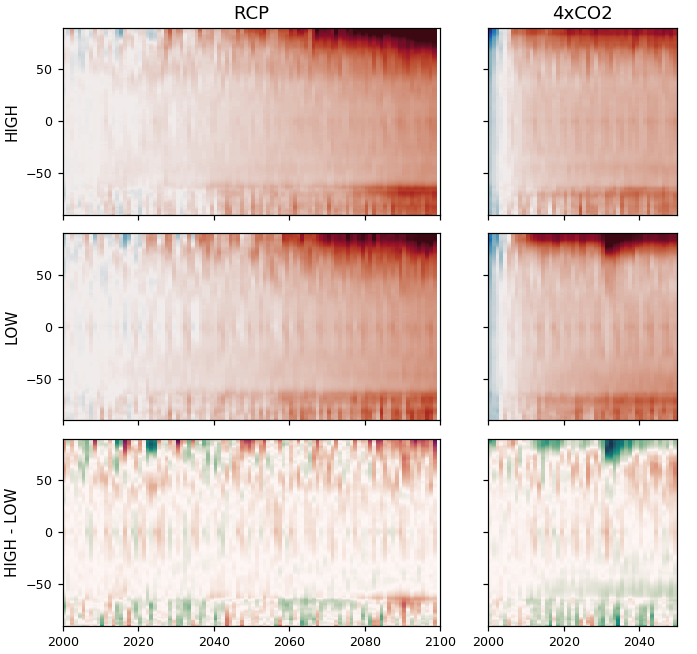

In [15]:
%%time
#21.1 s
f, ax = plt.subplots(3, 2, figsize=(6.4,6), sharex='col', sharey=True,
                     gridspec_kw={'width_ratios':[2,1]}, constrained_layout=True)
kw1 = {'vmin':-8, 'vmax':8, 'cmap':'cmo.balance'}
kw2 = {'vmin':-5, 'vmax':5, 'cmap':'cmo.curl'}
X1, Y1 = np.meshgrid(T_rcp.time/365+2000, T_rcp.lat)
X2, Y2 = np.meshgrid(T_lr1.time/365+2000, T_lr1.lat)
X3, Y3 = np.meshgrid(T_hq .time/365+2000, T_hq .lat)
X4, Y4 = np.meshgrid(T_lq .time/365+2000, T_lq .lat)

ax[0,0].pcolormesh(X1, Y1, T_rcp_zm  , **kw1)
ax[0,1].pcolormesh(X3, Y3, T_hq_zm   , **kw1)
ax[1,0].pcolormesh(X2, Y2, T_lr1_zm  , **kw1)
ax[1,1].pcolormesh(X4, Y4, T_lq_zm   , **kw1)
ax[2,0].pcolormesh(X2, Y2, T_rdiff_zm, **kw2)
ax[2,1].pcolormesh(X4, Y4, T_qdiff_zm, **kw2)
ax[0,0].set_ylabel('HIGH')
ax[1,0].set_ylabel('LOW')
ax[2,0].set_ylabel('HIGH - LOW')
ax[0,0].set_title('RCP')
ax[0,1].set_title('4xCO2')
ax[2,0].set_xlim(2000,2100)
ax[2,1].set_xlim(2000,2050)


Text(0.5, 0, 'latitude')

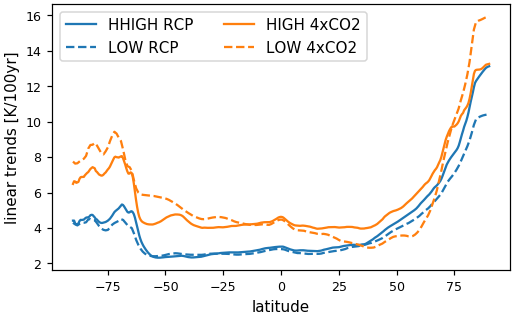

In [16]:
plt.plot(T_rcp.lat, xr_linear_trend(T_rcp.mean('lon'))*365*100, ls='-' , c='C0', label='HHIGH RCP'  )
plt.plot(T_lr1.lat, xr_linear_trend(T_lr1.mean('lon'))*365*100, ls='--', c='C0', label='LOW RCP'   )
plt.plot(T_hq .lat, xr_linear_trend(T_hq .mean('lon'))*365*100, ls='-' , c='C1', label='HIGH 4xCO2')
plt.plot(T_lq .lat, xr_linear_trend(T_lq .mean('lon'))*365*100, ls='--', c='C1', label='LOW 4xCO2' )
plt.legend(ncol=2)
plt.ylabel('linear trends [K/100yr]')
plt.xlabel('latitude')

Text(0.5, 0, 'latitude')

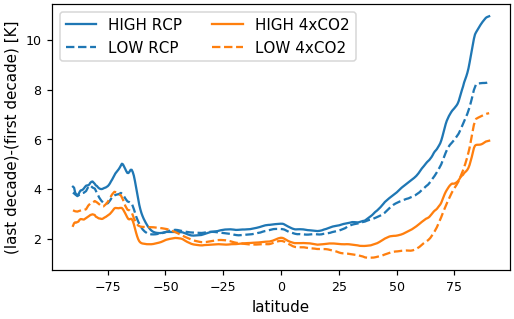

In [17]:
plt.plot(T_rcp.lat, (T_rcp.isel(time=slice(-11,-1)).mean('time')-T_rcp.isel(time=slice(0,10)).mean('time')).mean('lon'), ls='-' , c='C0', label='HIGH RCP'  )
plt.plot(T_lr1.lat, (T_lr1.isel(time=slice(-11,-1)).mean('time')-T_lr1.isel(time=slice(0,10)).mean('time')).mean('lon'), ls='--', c='C0', label='LOW RCP'   )
plt.plot(T_hq .lat, (T_hq .isel(time=slice(-11,-1)).mean('time')-T_hq .isel(time=slice(0,10)).mean('time')).mean('lon'), ls='-' , c='C1', label='HIGH 4xCO2')
plt.plot(T_lq .lat, (T_lq .isel(time=slice(-11,-1)).mean('time')-T_lq .isel(time=slice(0,10)).mean('time')).mean('lon'), ls='--', c='C1', label='LOW 4xCO2' )
plt.legend(ncol=2)
plt.ylabel('(last decade)-(first decade) [K]')
plt.xlabel('latitude')

The LOW 4xCO2 Arctic warms dramatically despite near AMOC collapse (much steeper gradient), that could mean, atmospheric heat flux much greater, or local feedbacks much stronger.

## mean, trend, variability

## OHC patterns see `CESM_104_vs_112_OHC.ipynb`

In [18]:
# # data to Robbin
# a = (gmst_rcp.rolling(time=12, center=True).mean()[6:12*100+6:12]).assign_coords(time=np.arange(2000,2100))
# b = (gmst_lr1.rolling(time=12, center=True).mean()[6:12*100+6:12]).assign_coords(time=np.arange(2000,2100))
# c = (gmst_hq .rolling(time=12, center=True).mean()[6:12*50 +6:12]).assign_coords(time=np.arange(2000,2050))
# d = (gmst_lq .rolling(time=12, center=True).mean()[6:12*50 +6:12]).assign_coords(time=np.arange(2000,2050))
# e = FTNT_rcp[:100].assign_coords(time=np.arange(2000,2100))
# f = FTNT_lr1[:100].assign_coords(time=np.arange(2000,2100))
# g = FTNT_hq [:50 ].assign_coords(time=np.arange(2000,2050))
# h = FTNT_lq [:50 ].assign_coords(time=np.arange(2000,2050))

# a.name = 'GMST HIGH RCP'
# b.name = 'GMST LOW RCP'
# c.name = 'GMST HIGH 4xCO2'
# d.name = 'GMST LOW 4xCO2'
# e.name = 'TOA HIGH RCP'
# f.name = 'TOA LOW RCP'
# g.name = 'TOA HIGH 4xCO2'
# h.name = 'TOA LOW 4xCO2'

# dsl = [a, b, c, d, e, f, g, h]

# xr.merge(dsl).to_netcdf(f'{path_results}/data_GMST_TOA_CESM.nc')
# ds = xr.open_dataset(f'{path_results}/data_GMST_TOA_CESM.nc', decode_times=False)

In [19]:
f = plt.figure(figsize=(6.4,6))

<Figure size 697.6x654 with 0 Axes>